<a href="https://colab.research.google.com/github/nupursjsu/AlternusVera/blob/master/Political_Affiliation_NupurYadav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Political Affiliation Factor

**Political Affiliation** means closeness to or supporting a particular political party.

It is a very important factor in determining if a news or statement is fake because party members usually stick to the party's philosophy and any digression from that is a good approximator of fakenews. So, I have tried to model this factor to check the credibility of news.

# Data Enrichment

For the purpose of data enrichment I have used **Kaggle Fake News dataset** which had similar domain data to that of liar liar dataset (comprises mainly of political topics)

[Link to Dataset](https://www.kaggle.com/mrisdal/fake-news)

# Important python libraries used



1.   NLTK
2.   gensim
3.   fastai



# General Approach

1. Get data from both liar and kaggle fakenews datasets
2. Initial data exploration
3. Remove unwanted columns
4. Clean the datasets using standard NLP practices such as stop word removal, lemmitization, stemming, removing puncuations etc.
5. Update the Party affiliation of liar dataset to include only four types
    *  Democrat
    *  Republican
    *  No-affiliation
    *  Other
9. Create corpus of text by combining both the datasets
10. Create Doc2Vec embeddings (length = 12) using genism for each tagged document
13. Feature Engineering : Use the generated doc2vec embeddings directly as features alongwith other categorical features such as state_info, speaker_job_title, context
14. Train a neural network on the above features which is using softmax and predicting a vector, which comprises the probability scores for each party affliation.
14. Update the fakeness label multiclasses to binary classes
    *   true, mostly-true and half-true to true
    *   false, barely-true and pants-fire to false
15. Use the probability scores generated to train a binary classification model (used Logistic Regression) to predict the fakeness of the given statement.

# Importing necessary libraries and loading datasets

In [251]:
import warnings
warnings.filterwarnings("ignore")

!pip install nltk
!pip install gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from nltk.stem.porter import *
from sklearn import metrics
import pickle


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
# Read data file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Loading Liar dataset

In [0]:
#Defining link to the liar dataset
link = 'https://drive.google.com/open?id=1Gw5NhXqsnWJnQURLkjnvhcmk5ExTB89X'
fluff, id = link.split('=')

#downloading the zip file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liar_dataset.zip')

import zipfile
with zipfile.ZipFile('liar_dataset.zip', 'r') as zip_ref:

    zip_ref.extractall()

liar_train = pd.read_csv('train.tsv', sep='\t',header=None)
liar_train=liar_train.drop(columns=[0])

liar_test = pd.read_csv('test.tsv', sep='\t',header=None)
liar_test=liar_test.drop(columns=[0])


In [0]:
columns=[
'label',
'statement',
'subject',
'speaker',
'speaker_job_title',
'state_info',
'affiliation',
'barely_true_counts',
'false_counts',
'half_true_counts',
'mostly_true_counts',
'pants_on_fire_counts',
'context'
]


liar_train.columns=columns
liar_test.columns=columns

In [145]:
#Combining train and test datasets
liar=pd.concat([liar_train,liar_test])
liar.head(2)


,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


### Cleaning Liar dataset

In [148]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanStatement

liar.dropna()
liar['CleanStatement'] = liar['statement'].map(lambda x: re.sub(r"\W", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: re.sub(r" \d+", " ",str(x)))
liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: word_tokenize(x.lower()))

liar['CleanStatement'] = liar['CleanStatement'].map(lambda x: ' '.join(x))
liar['CleanStatement'] = liar['CleanStatement'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

liar.head(2)

,label,statement,subject,speaker,speaker_job_title,state_info,affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,CleanStatement
0,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,says annies list political group supports third trimester abortions demand
1,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start started natural gas took started begin president george w bushs administration


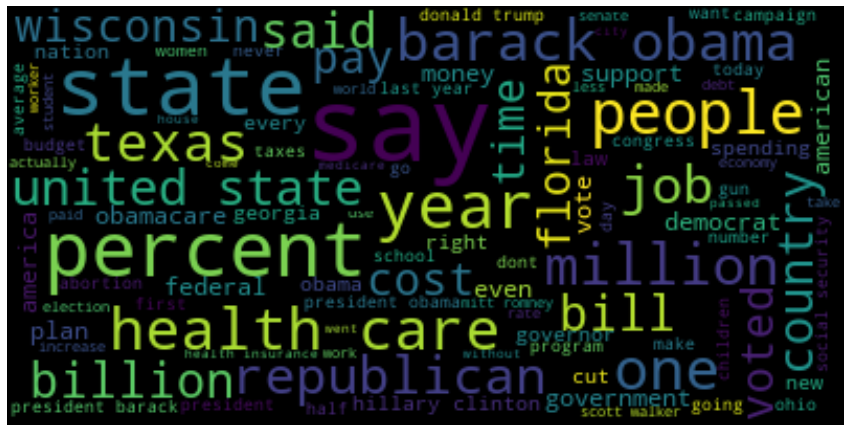

In [151]:
#Displaying wordcloud for Liar dataset
text= ' '.join(liar.CleanStatement)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

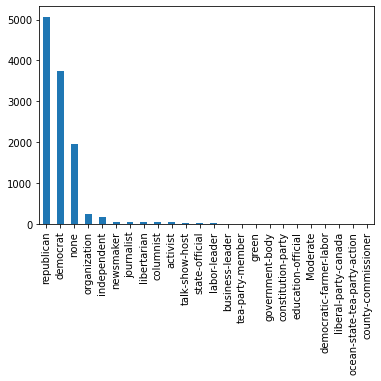

In [152]:
#looking at the distribution of party affiliation in the liar dataset
liar.affiliation.value_counts().plot(kind='bar')

In [0]:
def combine_party_affiliation_type(input_label):
    if input_label == 'none':
      return str('no-affiliation')
    elif input_label == 'democrat':
      return str('democrat')
    elif input_label == 'republican':
      return str('republican')
    else:
      return str('other')

liar['affiliation'] = liar.apply(lambda row: combine_party_affiliation_type(row['affiliation']), axis=1)

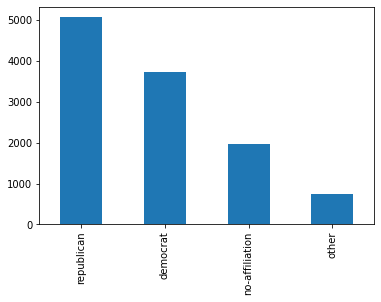

In [154]:
liar.affiliation.value_counts().plot(kind='bar')

## Loading Kaggle fake news dataset

In [0]:
link = 'https://drive.google.com/open?id=12UVATQQ5LJCXqYUm7JySfTJ_HvrJzcCq'
fluff, id = link.split('=')


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fake.csv')

fake_df = pd.read_csv('fake.csv')
fake_df=fake_df.drop(columns=['uuid','ord_in_thread', 'author', 'published',  'language', 'crawled', 'site_url', 'country', 'domain_rank', 'thread_title', 'spam_score'	,'main_img_url', 'replies_count', 'participants_count',	'likes',	'comments',	'shares',	'type' ])
fake_df=fake_df.drop_duplicates()

#dropping all the records where title is NaN
fake_df. dropna(subset = ['title'], inplace=True)

In [183]:
fake_df.head(2)

,title,text
0,Muslims BUSTED: They Stole Millions In Gov’t Benefits,Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related
1,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,"Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can’t recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! \n100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran…Corrupt to the core! Attorney General Loretta Lynch is declining to comply with an investigation by leading members of Congress about the Obama administration’s secret efforts to send Iran $1.7 billion in cash earlier this year, prompting accusations that Lynch has “pleaded the Fifth” Amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the Washington Free Beacon. \nSen. Marco Rubio (R., Fla.) and Rep. Mike Pompeo (R., Kan.) initially presented Lynch in October with a series of questions about how the cash payment to Iran was approved and delivered. \nIn an Oct. 24 response, Assistant Attorney General Peter Kadzik responded on Lynch’s behalf, refusing to answer the questions and informing the lawmakers that they are barred from publicly disclosing any details about the cash payment, which was bound up in a ransom deal aimed at freeing several American hostages from Iran. \nThe response from the attorney general’s office is “unacceptable” and provides evidence that Lynch has chosen to “essentially plead the fifth and refuse to respond to inquiries regarding [her]role in providing cash to the world’s foremost state sponsor of terrorism,” Rubio and Pompeo wrote on Friday in a follow-up letter to Lynch. More Related"


### **Cleaning Kaggle fake news data**

In [0]:
#Defining stop words for removal
stop_words = set(stopwords.words('english'))

#Removing punctations ,special characters and digits.
#Converting all the text to lower case and then work_tokenizing them and storing it in a column called CleanTitle and CleanText

fake_df['CleanTitle'] = fake_df['title'].map(lambda x: re.sub(r"\W", " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: re.sub(r" \d+", " ",str(x)))
fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: word_tokenize(x.lower()))

fake_df['CleanTitle'] = fake_df['CleanTitle'].map(lambda x: ' '.join(x))
fake_df['CleanTitle'] = fake_df['CleanTitle'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

fake_df['CleanText'] = fake_df['text'].map(lambda x: re.sub(r"\W", " ",str(x)))
fake_df['CleanText'] = fake_df['CleanText'].map(lambda x: re.sub(r'[,\.!?]', " ",str(x)))
fake_df['CleanText'] = fake_df['CleanText'].map(lambda x: re.sub(r" \d+", " ",str(x)))
fake_df['CleanText'] = fake_df['CleanText'].map(lambda x: word_tokenize(x.lower()))

fake_df['CleanText'] = fake_df['CleanText'].map(lambda x: ' '.join(x))
fake_df['CleanText'] = fake_df['CleanText'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [186]:
fake_df.head(2)

,title,text,CleanTitle,CleanText
0,Muslims BUSTED: They Stole Millions In Gov’t Benefits,Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? \nHere we go again …another group stealing from the government and taxpayers! A group of Somalis stole over four million in government benefits over just 10 months! \nWe’ve reported on numerous cases like this one where the Muslim refugees/immigrants commit fraud by scamming our system…It’s way out of control! More Related,muslims busted stole millions gov benefits,print pay back money plus interest entire family everyone came need deported asap take two years bust go another group stealing government taxpayers group somalis stole four million government benefits months reported numerous cases like one muslim refugees immigrants commit fraud scamming system way control related
1,Re: Why Did Attorney General Loretta Lynch Plead The Fifth?,"Why Did Attorney General Loretta Lynch Plead The Fifth? Barracuda Brigade 2016-10-28 Print The administration is blocking congressional probe into cash payments to Iran. Of course she needs to plead the 5th. She either can’t recall, refuses to answer, or just plain deflects the question. Straight up corruption at its finest! \n100percentfedUp.com ; Talk about covering your ass! Loretta Lynch did just that when she plead the Fifth to avoid incriminating herself over payments to Iran…Corrupt to the core! Attorney General Loretta Lynch is declining to comply with an investigation by leading members of Congress about the Obama administration’s secret efforts to send Iran $1.7 billion in cash earlier this year, prompting accusations that Lynch has “pleaded the Fifth” Amendment to avoid incriminating herself over these payments, according to lawmakers and communications exclusively obtained by the Washington Free Beacon. \nSen. Marco Rubio (R., Fla.) and Rep. Mike Pompeo (R., Kan.) initially presented Lynch in October with a series of questions about how the cash payment to Iran was approved and delivered. \nIn an Oct. 24 response, Assistant Attorney General Peter Kadzik responded on Lynch’s behalf, refusing to answer the questions and informing the lawmakers that they are barred from publicly disclosing any details about the cash payment, which was bound up in a ransom deal aimed at freeing several American hostages from Iran. \nThe response from the attorney general’s office is “unacceptable” and provides evidence that Lynch has chosen to “essentially plead the fifth and refuse to respond to inquiries regarding [her]role in providing cash to the world’s foremost state sponsor of terrorism,” Rubio and Pompeo wrote on Friday in a follow-up letter to Lynch. More Related",attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth barracuda brigade print administration blocking congressional probe cash payments iran course needs plead th either recall refuses answer plain deflects question straight corruption finest percentfedup com talk covering ass loretta lynch plead fifth avoid incriminating payments iran corrupt core attorney general loretta lynch declining comply investigation leading members congress obama administration secret efforts send iran billion cash earlier year prompting accusations lynch pleaded fifth amendment avoid incriminating payments according lawmakers communications exclusively obtained washington free beacon sen marco rubio r fla rep mike pompeo r kan initially presented lynch october series questions cash payment iran approved delivered oct response assistant attorney general peter kadzik responded lynch behalf refusing answer questions informing lawmakers barred publicly disclosing details cash payment bound ransom deal aimed freeing several american hostages iran response attorney general office unacceptable provides evidence lynch chosen essentially plead fifth refuse respond i

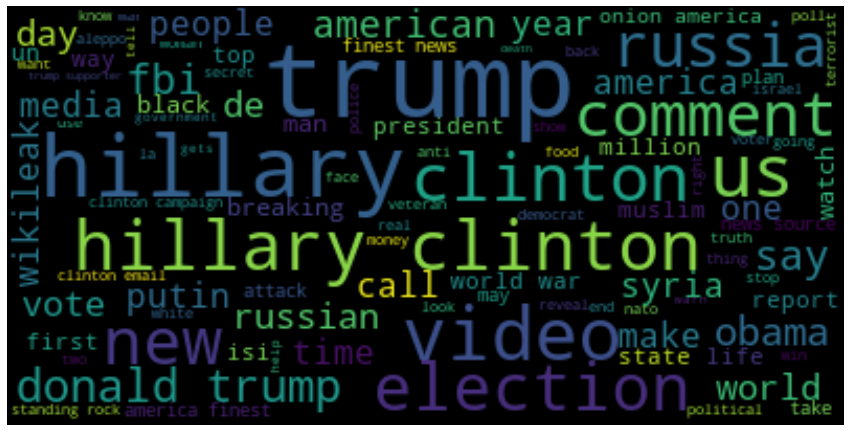

In [187]:
#Displaying wordcloud for Kaggle fake news dataset
text= ' '.join(fake_df.CleanTitle)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black",normalize_plurals=True).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Combining text in both the datasets to create a doc2vec model

In [0]:
data = []
data = liar.CleanStatement.tolist() + fake_df.CleanTitle.tolist()

In [207]:
#Generating tagged documents for training doc2vec model
tagged_data = []
exception_count = 0
for i, _d in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]))
    except:
        exception_count+=1

tagged_data[0]


TaggedDocument(words=['says', 'annies', 'list', 'political', 'group', 'supports', 'third', 'trimester', 'abortions', 'demand'], tags=['0'])

# Train Doc2Vec Model

In [285]:
#Initializing hyperparameters for doc2vec model
max_epochs = 10
vec_size = 12
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=10,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    #Decreasing the learning rate with very iteration
    model.alpha -= 0.0002
    #Fixing the learning rate, for no decay
    model.min_alpha = model.alpha

model.save("doc2vec1.model")
print("Doc2Vec Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Doc2Vec Model Saved


In [287]:
#Checking the embeddings generated by doc2vec model for a given text sample
text = "decline coal start started natural gas took started begin president george w bushs administration"
d2vmodel= Doc2Vec.load("doc2vec1.model")
test_ex= [d2vmodel.infer_vector(word_tokenize(text))]
print(test_ex)

[array([-0.316288,  0.252407,  0.400897, -0.222462,  0.223107,  0.282663, -0.26583 ,  0.205249,  0.347018, -0.072854,
       -0.393441, -0.42063 ], dtype=float32)]


# Creating Training dataset for Neural Network 

Training a neural network on the doc2vec embeddings generated for statement feature and other categorical features from liar dataset such as state, job_title and context to generate a probability vector which gives the probability scores for each party affiliation. 

Neural network is using softmax at the output layer to generate these probability scores and make the prediction for party affiliation as the one with the highest probability.

In [0]:
#Generating word embeddings for cleanstatement in liar dataset using previously trained Doc2Vec model
statement_wordvec = []
for statement in liar.CleanStatement.tolist():
    statement_wordvec.append(d2vmodel.infer_vector(word_tokenize(statement)))

In [0]:
#Defining training data for Neural Network
df = pd.DataFrame(statement_wordvec)
df['speaker_job_title']= liar.speaker_job_title.tolist()
df['state_info'] = liar.state_info.tolist()
df['context'] = liar.context.tolist()
df['party_affiliation'] = liar.affiliation.tolist()

df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','Embed_10', 'Embed_12', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

In [290]:
#Displaying training data for Neural network
df.tail(5)

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,Embed_10,Embed_12,speaker_job_title,state_info,context,party_affiliation
11502,0.042167,0.097511,0.163414,-0.062737,0.285780,-0.080094,-0.091670,0.555897,0.205270,0.257854,0.041791,-0.127502,Governor,Florida,a news conference,republican
11503,-0.113670,0.060829,0.126898,0.000564,0.210060,0.061372,-0.057043,0.285462,0.182197,0.186593,-0.006690,-0.115090,Governor,Missouri,"on ABC's ""This Week""",democrat
11504,0.021856,-0.185158,0.050250,0.341246,0.069753,0.272539,0.059584,0.222954,-0.044138,0.017226,0.016278,-0.161520,"senior fellow, Foreign Policy Research Institute",Rhode Island,a commentary in The Providence Journal,other
11505,-0.092692,-0.011422,0.078053,0.226688,0.178444,0.030473,-0.113949,0.318871,0.029539,-0.056551,0.014967,-0.062691,"Governor of Ohio as of Jan. 10, 2011",Ohio,a news conference,republican
11506,-0.004561,-0.042966,0.246935,-0.076558,0.577731,0.054057,0.006993,0.110784,0.227352,0.260775,0.045258,-0.125879,NaN,NaN,an interview with NJToday,democrat


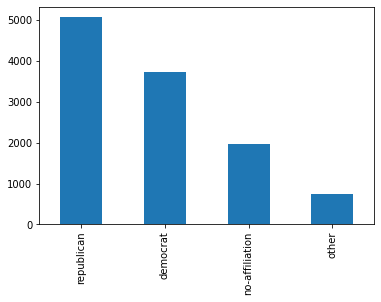

In [291]:
#Displaying party affiliation dustribution across the training dataset
df.party_affiliation.value_counts().plot(kind='bar')#(10)

# Building the Neural Network model

In [292]:
#Splitting dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.15, random_state=1)

len(train_df), len(test_df)

(9780, 1727)

In [0]:
# Defining pre-processing we want for our fast.ai DataBunch
procs=[FillMissing, Categorify, Normalize]

In [0]:
# Preparing categorical and continous data columns for building Tabular DataBunch.
cat_vars = ['speaker_job_title', 'state_info', 'context' ]
cont_vars = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9','Embed_10', 'Embed_12']

In [0]:
# Defining the dependent (target) variable
dep_var = 'party_affiliation'

In [0]:
#Specifying the valid_idx variable as the cut out range.
valid_idx = range(1727)

In [0]:
path= Path()
train_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','Embed_10', 'Embed_12', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']
test_df.columns = df.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7', 'Embed_8', 'Embed_9','Embed_10', 'Embed_12', 'speaker_job_title', 'state_info', 'context', 'party_affiliation']

#Preparing a test dataset
test = TabularList.from_df(test_df, path=path, cat_names=None, cont_names=cont_vars)

In [304]:
# Use fast.ai datablock api to put our training data into the DataBunch, getting ready for training
data = (TabularList.from_df(train_df, path=Path(), cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var)
                   .add_test(test, label=0)
                   .databunch())
data.show_batch(rows=10)

speaker_job_title,state_info,context,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,Embed_10,Embed_12,target
Philadelphia Mayor,Pennsylvania,Philadelphia Mayor Jim Kenney clarified his stance on stop and frisk to the Al Día editorial board.,-0.0507,0.2566,-0.2414,0.2020,0.9448,0.3433,0.1043,0.4183,0.3812,0.1912,-0.6769,-1.3290,democrat
President,Illinois,#na#,-0.7296,0.3350,0.5258,-0.3282,0.8304,-0.7347,0.5279,0.7020,1.1307,0.5651,0.2043,-0.6705,democrat
#na#,#na#,a web ad.,2.1012,-0.3029,-0.9269,1.4896,-1.6299,-0.8737,3.1200,-0.8712,-1.5598,-0.6055,1.3176,0.7396,democrat
Milwaukee County Executive,Wisconsin,a book,0.3362,-0.4985,-0.0822,2.8045,-1.3465,-0.6933,-0.5043,-0.7777,1.0196,-0.2678,0.3158,-0.4033,republican
former president,Arkansas,an interview on ABC's This Week,-0.5028,-0.8566,-0.2194,0.7877,0.8098,0.0892,-1.0947,0.7799,-0.6621,-0.8795,-0.2186,-0.1937,democrat
#na#,Florida,a rally announcing his candidacy for governor,-0.8739,0.4250,1.0135,-1.9593,0.8437,-1.3333,-1.8461,0.1524,0.6801,1.6699,2.3059,-1.2394,democrat
Social media posting,#na#,a Facebook comment,-0.0023,0.2457,-0.0045,-0.2116,0.5378,-0.5279,0.1445,-0.1545,-0.9561,0.3630,-0.7663,0.8165,no-affiliation
Senator,Texas,an interview with CBS' Stephen Colbert,-2.0240,-0.8262,0.5056,2.1870,-0.2614,-0.5572,-1.6931,-0.4479,-1.0282,0.6355,1.5944,1.6314,republican
#na#,#na#,a telephone campaign,-0.2191,1.8574,1.3171,0.4732,1.9671,2.2313,0.6661,2.0061,1.3148,1.9766,-1.1958,-0.8929,democrat
Trade group representing the health insurance industry,"Washington, D.C.",an advertisement,-1.0728,0.8313,-0.3104,-0.6840,0.2945,-0.6623,-0.6123,0.2340,0.1901,0.4611,0.6804,-0.3417,no-affiliation


In [0]:
#defining the model
learn = tabular_learner(data, layers=[30,15,4],  metrics=accuracy,emb_drop=0.2)

In [306]:
#displaying the model parameters
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1034, 78)
    (1): Embedding(76, 18)
    (2): Embedding(3582, 156)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=264, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=30, out_features=15, bias=True)
    (4): ReLU(inplace=True)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=4, bias=True)
    (7): ReLU(inplace=True)
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [336]:
#fitting the learner and kept learning rate as le-3 because you can see in below learning rate curve the loss is minimum for this value
learn.fit_one_cycle(8,1e-2) 
#Saving the model
learn.save("NN_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.185747,0.701291,0.730168,00:02
1,0.246641,0.784910,0.702953,00:02
2,0.281679,0.672144,0.722640,00:02
3,0.264056,0.688549,0.727852,00:02
4,0.224009,0.695037,0.742907,00:02
5,0.196176,0.717384,0.745802,00:02
6,0.159111,0.726880,0.742328,00:02
7,0.145599,0.738416,0.744065,00:02


The NN model is achieving an accuracy of `74%` approx.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


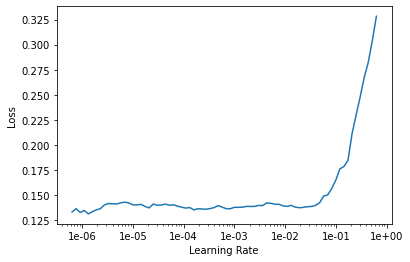

In [337]:
#Plotting the learning rate curve of the model
learn.lr_find()
learn.recorder.plot()

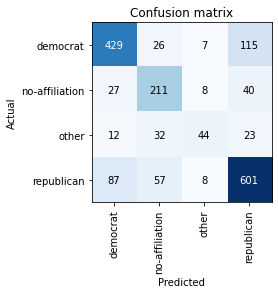

In [339]:
#Plotting the confusion matrix for the NN model
pred = ClassificationInterpretation.from_learner(learn)
pred.plot_confusion_matrix()

In [340]:
#Displaying the prediction for one of the test record
print(test_df.iloc[3],str(learn.predict(test_df.iloc[0])))

Embed_0             -0.155423       
Embed_1              0.150522       
Embed_2              0.227503       
Embed_3              0.128789       
Embed_4              0.27507        
Embed_5              0.0165146      
Embed_6             -0.187004       
Embed_7              0.547379       
Embed_8              0.281623       
Embed_9              0.347688       
Embed_10             0.010258       
Embed_12            -0.19953        
speaker_job_title    Former governor
state_info           Massachusetts  
context              a column       
party_affiliation    republican     
Name: 2201, dtype: object (Category democrat, tensor(0), tensor([9.8996e-01, 5.2217e-04, 1.8236e-03, 7.6903e-03]))


You can see the NN model has predicted the affiliation correctly as 'republican' and have also provided us a vector denoting probaility scores towards each party affiliation. Further we will be using these scores to identify fakeness of news.

Applying the NN trained model on liar liar dataset with statement word embeddings to get predicted party and their confidence towards each party.

#Running the trained NN model on our liar dataset to get the probability scores vector for party affiliation

In [341]:
#Defining the data to run model on
df_final = df.drop('party_affiliation', axis=1)
df_final.columns = ['Embed_0', 'Embed_1', 'Embed_2', 'Embed_3', 'Embed_4', 'Embed_5', 'Embed_6', 'Embed_7','Embed_8', 'Embed_9','Embed_10', 'Embed_12','speaker_job_title','state_info','context']
df_final.head()

,Embed_0,Embed_1,Embed_2,Embed_3,Embed_4,Embed_5,Embed_6,Embed_7,Embed_8,Embed_9,Embed_10,Embed_12,speaker_job_title,state_info,context
0,0.207843,0.161497,0.084413,0.066096,0.230011,0.009770,-0.043441,0.379795,-0.006960,0.087166,-0.017780,-0.058756,State representative,Texas,a mailer
1,-0.343795,0.168326,0.346432,-0.104958,0.246740,0.193511,-0.209347,0.171341,0.428001,-0.018768,-0.356874,-0.292600,State delegate,Virginia,a floor speech.
2,-0.060002,-0.172926,-0.068516,-0.263994,-0.019431,-0.006987,0.052463,-0.119780,0.121269,-0.113839,0.271380,-0.294060,President,Illinois,Denver
3,0.033416,0.377561,0.015410,0.013934,0.034507,-0.013594,-0.073224,0.249277,0.342495,0.330401,0.046878,-0.085571,NaN,NaN,a news release
4,-0.206791,-0.050793,0.116180,0.160881,0.286370,0.042911,-0.238750,0.227317,0.159622,0.060869,0.015288,-0.209637,NaN,Florida,an interview on CNN


In [0]:
#Running the NN model to predict the party affiliation vector
def predict_partyaffiliation():

  #loading already trained NN model to get respective probability scores towards each individual party for every record in liar dataset
  learn.load("NN_model")
  probability_vector =[]
  prediction =[]
  for i in range(0,len(df_final)):
    pred = learn.predict(df_final.iloc[i])
    prediction.append(pred[0])
    probability_vector.append(pred[2])

In [0]:
##Converting the probailities obtained as a tensor to vectors so that it can be added to dataframe as columns
import numpy as np
prob_vector = []
for vector in probability_vector:
    v =[]
    for i in vector:
        a = float(i)
        v.append(a)
    prob_vector.append(v)

In [344]:
#Creating final training data to predict fakeness based on the probabilities towards each party affiliation
columns = ['Prob_republican','Prob_democrat','Prob_no_affliation','Prob_other', 'label']
final_df = pd.DataFrame(prob_vector)
final_df['label'] = liar.label.tolist()
final_df.columns = columns
final_df.head()

,Prob_republican,Prob_democrat,Prob_no_affliation,Prob_other,label
0,0.091558,0.012357,0.020072,0.876013,false
1,0.926324,0.010031,0.033270,0.030375,half-true
2,0.979360,0.012965,0.003983,0.003691,mostly-true
3,0.372151,0.260208,0.253428,0.114214,false
4,0.191907,0.188918,0.069532,0.549643,half-true


In [0]:
#Converting labels to either true 0 or false 1
    def convertMulticlassToBinaryclass(v):
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'

final_df['label']=final_df['label'].map(lambda v: convertMulticlassToBinaryclass(v))

In [346]:
final_df.head()

,Prob_republican,Prob_democrat,Prob_no_affliation,Prob_other,label
0,0.091558,0.012357,0.020072,0.876013,0
1,0.926324,0.010031,0.033270,0.030375,1
2,0.979360,0.012965,0.003983,0.003691,1
3,0.372151,0.260208,0.253428,0.114214,0
4,0.191907,0.188918,0.069532,0.549643,1


In [0]:
#Splitting the data into train set and training set
X = final_df.drop('label', axis=1)
Y = final_df.label
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=1 )

# Training Logistic Regression model to predict fakeness of statement using the probability scores obtained using NN model

In [351]:
model = LogisticRegression()
model = model.fit(X_train, Y_train)
pred = model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)*100
print("Party Affiliation Model Trained - accuracy:   %0.6f" % score)

Party Affiliation Model Trained - accuracy:   55.993052


In [0]:
predictedProb = model.predict_proba(X_test)[:,1]

In [350]:
print(predictedProb)

[0.532451 0.499821 0.644492 0.504849 ... 0.508994 0.549011 0.673622 0.503659]


# Conclusion

I have modeled party affiliation factor to check the fakeness of news or statement and the logistic regression model is giving an accuracy of approx 56%.

As next steps I will try to amalgamate more datasets to see if this improves the accuracy. Also, I will try to run other models for final classification to check if some other model is out-performing Logistic Regression.

# References


1.   https://www.programcreek.com/python/example/103013/gensim.models.doc2vec.TaggedDocument
2.   https://towardsdatascience.com/how-to-gain-state-of-the-art-result-on-tabular-data-with-deep-learning-and-embedding-layers-d1eb6b83c52c

